## Load saved models

In [1]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from model import VQVAE
from pixelcnn import PixelCNN

DATA_DIR = 'datasets/mnist'
DATA_SET = 'mnist'
MODEL_DIR = 'models/mnist/'
VQVAE_MODEL = MODEL_DIR + 'last.ckpt'
PIXELCNN_MODEL = MODEL_DIR + 'last-pixelcnn.ckpt'
K = 4
D = 128
BETA = 0.25
NUM_CLASSES = 10
NUM_LAYERS = 12
NUM_FEATURE_MAPS = 32

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

with tf.variable_scope('net'):
    with tf.variable_scope('params') as params:
        pass
    x = tf.placeholder(tf.float32,[None,784])
    resized = tf.image.resize_images(tf.reshape(x,[-1,28,28,1]),(24,24))

    vqvae_net = VQVAE(None,
                None,
                BETA,
                resized,
                K,
                D,
                DATA_SET,
                params,
                False)
    
with tf.variable_scope('pixelcnn'):
    pixelcnn_net = PixelCNN(None,
                            None,
                            None,
                            vqvae_net.k.get_shape()[1],
                            vqvae_net.embeds,
                            K,
                            D,
                            NUM_CLASSES,
                            NUM_LAYERS,
                            NUM_FEATURE_MAPS,
                            False)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.graph.finalize()
sess.run(init_op)
vqvae_net.load(sess,VQVAE_MODEL)
pixelcnn_net.load(sess,PIXELCNN_MODEL)

#coord = tf.train.Coordinator()
#threads = tf.train.start_queue_runners(coord=coord,sess=sess)

Extracting datasets/mnist/train-images-idx3-ubyte.gz
Extracting datasets/mnist/train-labels-idx1-ubyte.gz
Extracting datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting datasets/mnist/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from models/mnist/last.ckpt
INFO:tensorflow:Restoring parameters from models/mnist/last-pixelcnn.ckpt


# Reconstruction - Test set

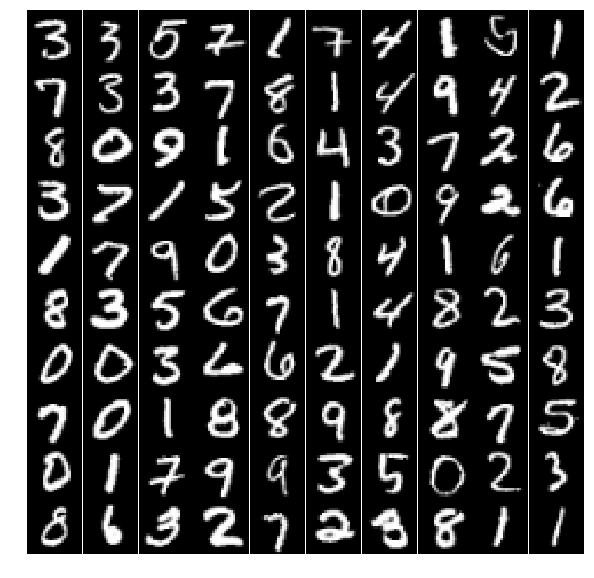

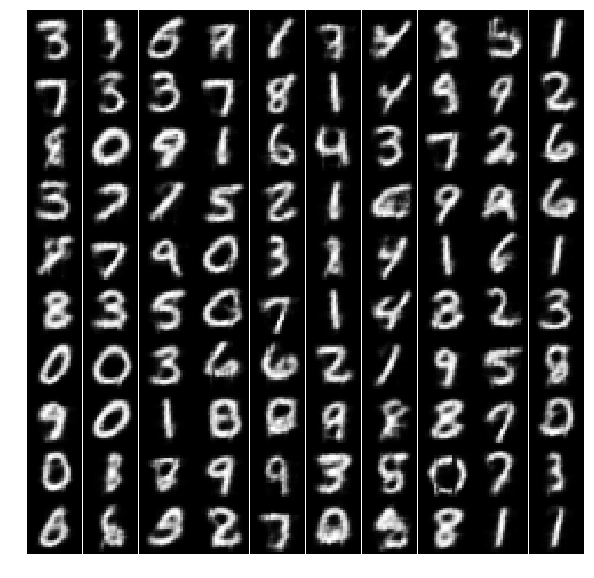

In [6]:
def draw(images):
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(10,10))
    for n, image in enumerate(images):
        a = fig.add_subplot(10, 10, n + 1)
        a.imshow( np.squeeze((image*255.0)).astype(np.uint8), cmap='gray' )
        a.axis('off')
        a.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()
    
ims, _= mnist.test.next_batch(100)
test_origin, test_recons = sess.run([resized,vqvae_net.reconstruction],feed_dict={x:ims})
draw(test_origin)
draw(test_recons)

## Reconstruction - Training set

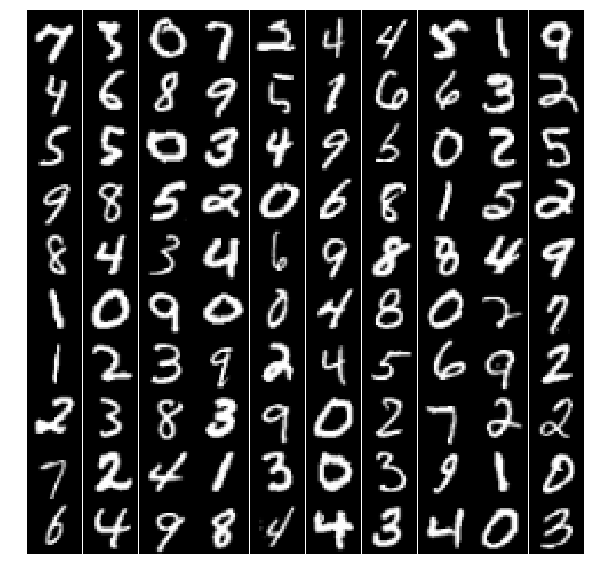

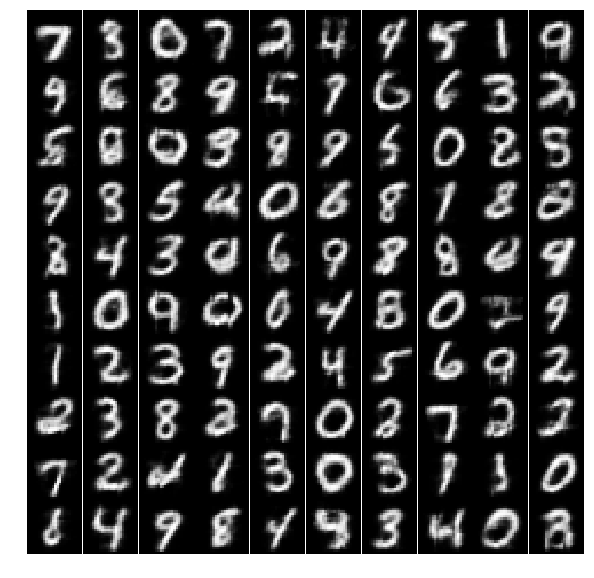

In [7]:
ims, _= mnist.train.next_batch(100)
train_origin, train_recons = sess.run([resized,vqvae_net.reconstruction],feed_dict={x:ims})
draw(train_origin)
draw(train_recons)

## Samples with Class Conditioned

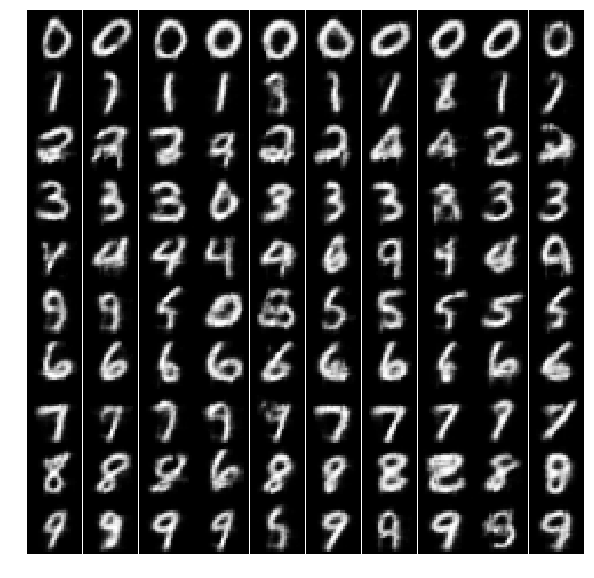

In [11]:
samples_latent,log_probs = pixelcnn_net.sample_from_prior(sess,np.arange(10),10)
#print(len(sampled_zs))
#print(len(sampled_zs[0]))
#print(sampled_zs)
sampled_ims = sess.run(vqvae_net.gen,feed_dict={vqvae_net.latent:samples_latent})
draw(sampled_ims)